# Trabalho 1 - Autoencoder variacional

Igor Amarao Correa
20.83992-8

# Dataset

Os dados foram retirados do repositorio  https://drive.google.com/file/d/1HG7YnakUkjaxtNMclbl2t5sJwGLcHYsI/view?usp=sharing, que sao imagens de rostos de animes.

Resultado de um scrape, devidamente documentado no github  https://github.com/bchao1/Anime-Face-Dataset

Para consumir as imagens, basta fazer o download do arquivo zip e aloca-las no google drive.

## Lendo as Images

As imagens inicialmente zipadas, serao lidas na sessao do colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/pos/gans/data.zip","r") as zip_ref:
  zip_ref.extractall("targetdir")

In [3]:
# load all images in a directory
from os import listdir
from matplotlib import image
from PIL import Image
import numpy as np
# load all images in a directory
loaded_images = list()
images_path = '/content/targetdir/data/cropped/'
for filename in listdir(images_path):
    try:
      # load image
      img_data = Image.open(images_path+ filename)
      # store loaded image
      loaded_images.append(np.array(img_data.resize((32,32))))
    except:
      pass
loaded_images = np.asarray(loaded_images)

In [4]:
loaded_images.shape

(63569, 32, 32, 3)

# Normalizando as Images

Normalizar os dados, de maneira que fiquem entre 0 e 1.

zi=xi−min(x) / max(x)−min(x)

In [5]:
loaded_images = (loaded_images - np.min(loaded_images)) / (np.max(loaded_images) - np.min(loaded_images))

# Configurando o Amostrador

In [6]:
# Importa classe de camadas e Keras backend
import tensorflow.keras.backend as K
from tensorflow.keras import layers
import tensorflow as tf
# Classe de camada do amsotrador
class Sampling(layers.Layer):
  # Método para inicializar classe
  def __init__(self):
  # Inicializa classe
    super(Sampling, self).__init__()

  # Método para realizar cálculos na camada do amsotrador
  def call(self, inputs):
    """Dados de entrada: 
    Vetor de médias: z_mean;
    Logaritmo do vetor de variâncias: z_log_var"""

    # Separa média e desvio padrão da entrada na forma de lista
    z_mean, z_log_var = inputs

    # Recupera dimensões dos tensores de média e desvio padrão
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]

    # Gera número aleatório com distribuição Gaussiana de média 0 e desvio padrão 1
    alfa = K.random_normal(shape=(batch, dim))

    # Retorna vetor de código amostrado
    return z_mean + tf.exp(0.5 * z_log_var) * alfa

# Configurando o Codificador

In [7]:
# Importa camadas necessárias
from tensorflow.keras.models import Model,Sequential

shape = loaded_images.shape[1:4]
encoder_input = layers.Input(shape)

x = layers.Conv2D(32, kernel_size=3, strides=2, padding='same', activation=layers.LeakyReLU())(encoder_input)
x = layers.Conv2D(32, kernel_size=3, strides=2, padding='same', activation=layers.LeakyReLU())(x)
x = layers.Conv2D(32, kernel_size=3, strides=2, padding='same', activation=layers.LeakyReLU())(x)
x = layers.BatchNormalization()(x)

conv_shape = K.int_shape(x)

x = layers.Flatten()(x)

latent_dim = 2
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

z = Sampling()([z_mean, z_log_var])

encoder = Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
print(encoder.summary()) 

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 8, 32)     9248        conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 4, 4, 32)     9248        conv2d_1[0][0]                   
____________________________________________________________________________________________

# Configurando o Decodificador

In [8]:
decoder_input  = layers.Input(shape=(latent_dim,))

# decoder_input = layers.Input(shape=(decoder_input,))
decoder = layers.Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
decoder = layers.Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(decoder)



decoder_conv = layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu')(decoder)
decoder_conv = layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding='same', activation='relu')(decoder_conv)
decoder_conv = layers.Conv2DTranspose(8, kernel_size=3, strides=2, padding='same', activation='relu')(decoder_conv)
# decoder_conv = layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu')(decoder_conv)
decoder_outputs = layers.Conv2D(3, kernel_size=1, strides=1, padding='same', activation='sigmoid')(decoder_conv)

decoder = Model(decoder_input, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense (Dense)                (None, 512)               1536      
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 32)          9248      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 16)        4624      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 8)         1160      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 3)         27  

# Termo de Regularizacao KL da Funcao de Custo

In [9]:
# Termo de regularização KL
def KL_loss(z_mean, z_log_var):
  # calcula desvio padrão
  sigma = tf.exp(0.5 * z_log_var)
  
  # Calcula custo KL
  kl_loss = 0.5*(sigma**2 + z_mean**2 - z_log_var - 1.0)
  
  # Calcula média do resultado
  kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
  
  return kl_loss

# Autoencoder completo

In [10]:
# define fator de regularização

beta = 1/(32*32)
# Camada de entrada
inputs = layers.Input(shape=(shape))
# Inclui codificador
z_mean, z_log_var, z = encoder(inputs)
# Incluir decodificador
decoder_output = decoder(z)
# Instância AEV
AEV = Model(inputs, decoder_output)
# Define termo de regularização KL 
loss = beta*KL_loss(z_mean, z_log_var)
# Adiciona termo de regularização KL omo função de custo adicional
AEV.add_loss(loss)
# Summario do AEV
AEV.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 2), (None, 2 21572       input_3[0][0]                    
__________________________________________________________________________________________________
decoder (Functional)            (None, 32, 32, 3)    16595       encoder[0][2]                    
__________________________________________________________________________________________________
tf.math.multiply (TFOpLambda)   (None, 2)            0           encoder[0][1]                    
______________________________________________________________________________________________

# Compilacao do Autoencoder

In [11]:
# Define otimizador Adam
adam = tf.keras.optimizers.Adam(learning_rate=0.001, decay=0.5e-02)
# Compilação do autoencoder
AEV.compile(optimizer=adam, loss='binary_crossentropy', metrics=['binary_accuracy'])

# Treinamento do Autoencoder

In [12]:
results = AEV.fit(x=loaded_images, 
                  y=loaded_images, 
                  epochs=150, 
                  batch_size=256,
                  shuffle=True)


Epoch 1/150
249/249 [==============================] - 36s 16ms/step - loss: 0.6268 - binary_accuracy: 0.0298
Epoch 2/150
249/249 [==============================] - 4s 15ms/step - loss: 0.5986 - binary_accuracy: 0.0296
Epoch 3/150
249/249 [==============================] - 4s 15ms/step - loss: 0.5915 - binary_accuracy: 0.0290
Epoch 4/150
249/249 [==============================] - 4s 15ms/step - loss: 0.5896 - binary_accuracy: 0.0292
Epoch 5/150
249/249 [==============================] - 4s 15ms/step - loss: 0.5889 - binary_accuracy: 0.0292
Epoch 6/150
249/249 [==============================] - 4s 16ms/step - loss: 0.5884 - binary_accuracy: 0.0293
Epoch 7/150
249/249 [==============================] - 4s 15ms/step - loss: 0.5881 - binary_accuracy: 0.0293
Epoch 8/150
249/249 [==============================] - 4s 15ms/step - loss: 0.5879 - binary_accuracy: 0.0293
Epoch 9/150
249/249 [==============================] - 4s 15ms/step - loss: 0.5877 - binary_accuracy: 0.0293
Epoch 10/150
249/2

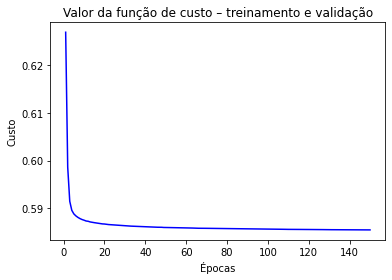

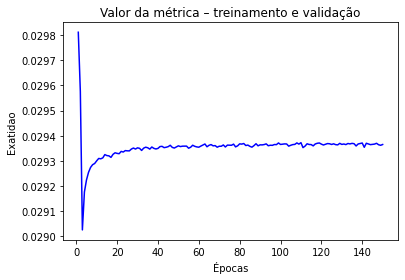

In [13]:
import matplotlib.pyplot as plt

def plot_train(history):
 history_dict = history.history
 # Salva custos, métricas em vetores 
 custo = history_dict['loss']
 acc = history_dict['binary_accuracy']
 # Cria vetor de épocas
 epocas = range(1, len(custo) + 1)
 # Gráfico dos valores de custo
 plt.plot(epocas, custo, 'b', label='Custo - treinamento')
 plt.title('Valor da função de custo – treinamento e validação')
 plt.xlabel('Épocas')
 plt.ylabel('Custo')
 plt.show()
 # Gráfico dos valores da métrica
 plt.plot(epocas, acc, 'b', label='exatidao- treinamento')
 plt.title('Valor da métrica – treinamento e validação')
 plt.xlabel('Épocas')
 plt.ylabel('Exatidao')
 plt.show()
plot_train(results)


# Avaliacao do Autoencoder

In [14]:
AEV.evaluate(loaded_images, loaded_images)

1987/1987 [==============================] - 7s 3ms/step - loss: 0.5855 - binary_accuracy: 0.0294


[0.5854815244674683, 0.02937604859471321]

# Comparação das saídas previstas pelo autoencoder com as entradas


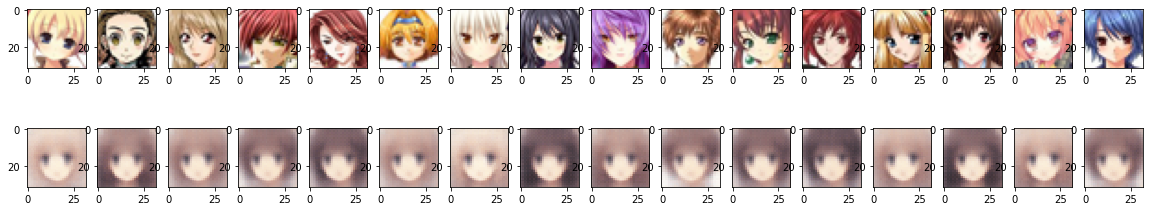

In [15]:
# Calcula dados reconstriuídos pelo AE
x_prev = 255*AEV.predict(loaded_images)
x_prev = x_prev.astype(int)
#Plot
f, pos = plt.subplots(2, 16, figsize=(20, 4))
for i in range(16):
  # plt.imshow(x_prev[0], interpolation='nearest')
  pos[0,i].imshow((loaded_images[i]*255).astype(int), cmap='gray')
  pos[1,i].imshow(x_prev[i], interpolation='nearest')
plt.show()

In [16]:
#erro e metrica para cada uma das images
for i in range(16):
  print(f"imagem numero {i}")
  AEV.evaluate(loaded_images[i:i+1], loaded_images[i:i+1])

imagem numero 0
1/1 [==============================] - 0s 97ms/step - loss: 0.4906 - binary_accuracy: 0.0374
imagem numero 1
1/1 [==============================] - 0s 15ms/step - loss: 0.6261 - binary_accuracy: 0.0260
imagem numero 2
1/1 [==============================] - 0s 20ms/step - loss: 0.6092 - binary_accuracy: 0.0143
imagem numero 3
1/1 [==============================] - 0s 15ms/step - loss: 0.6423 - binary_accuracy: 0.0033
imagem numero 4
1/1 [==============================] - 0s 14ms/step - loss: 0.6180 - binary_accuracy: 0.0221
imagem numero 5
1/1 [==============================] - 0s 15ms/step - loss: 0.5796 - binary_accuracy: 0.0316
imagem numero 6
1/1 [==============================] - 0s 20ms/step - loss: 0.4674 - binary_accuracy: 0.0365
imagem numero 7
1/1 [==============================] - 0s 18ms/step - loss: 0.6059 - binary_accuracy: 0.0101
imagem numero 8
1/1 [==============================] - 0s 14ms/step - loss: 0.6131 - binary_accuracy: 0.0085
imagem numero 9
1/1

In [17]:
AEV.evaluate(loaded_images[1:2], loaded_images[1:2])

1/1 [==============================] - 0s 14ms/step - loss: 0.6285 - binary_accuracy: 0.0260


[0.6284918785095215, 0.0260416679084301]

# Geração de novas imagens de dígitos

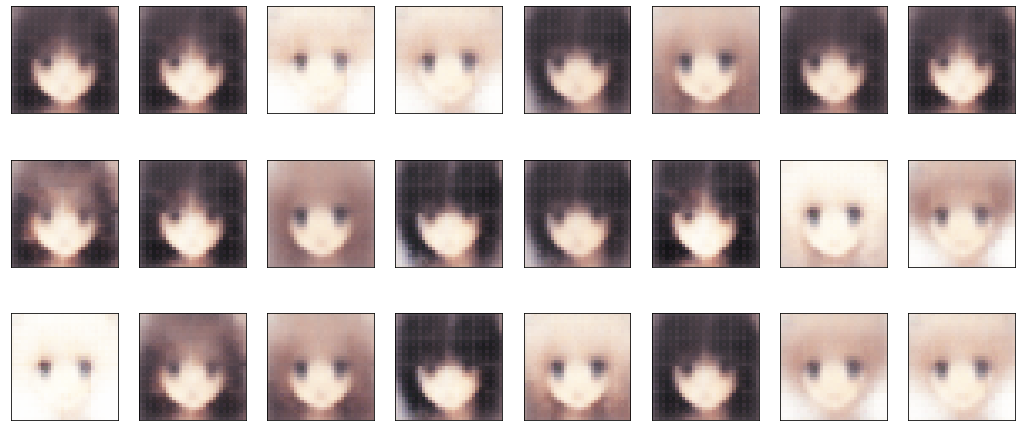

In [18]:
# representações latente geradas aleatóriamente
# Alterar sacle para selecionar dígitos diferentes
scale = 2.
z_rand = np.random.randn(24,latent_dim) + 2.0*scale*(np.random.randint(0, 2, (24, latent_dim)) - 0.5)
 
# Cria imagem a partir da representação latente 
reconst_images_vec = decoder.predict(z_rand)

# Mostra imagens construídas
f, pos = plt.subplots(3, 8, figsize=(18, 8))
for i in range(3):
  for j in range(8):
    index = i*8 + j
    pos[i,j].imshow(np.squeeze(reconst_images_vec[index]), cmap='gray')
    pos[i,j].axes.xaxis.set_visible(False)
    pos[i,j].axes.yaxis.set_visible(False)
plt.show()

# Grade de dígitos


In [19]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=16):
	# generate points in the latent space
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	return z_input
 
# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=8):
	# interpolate ratios between the points
	ratios = np.linspace(0, 1, num=n_steps)
	# linear interpolate vectors
	vectors = list()
	for ratio in ratios:
		v = (1.0 - ratio) * p1 + ratio * p2
		vectors.append(v)
	return np.asarray(vectors)
 
# create a plot of generated images
def plot_generated(examples, n):
  # plot images
  for i in range(n * n):
    # define subplot
    plt.subplot(n, n, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(examples[i, :, :])

  
  plt.show()

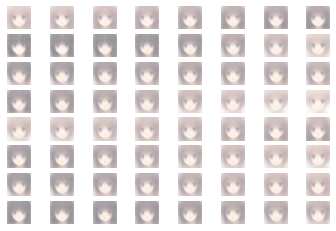

In [20]:
# generate points in latent space
n = 20
pts = generate_latent_points(2, n)
# interpolate pairs
results = None
for i in range(0, n, 2):
	# interpolate points in latent space
	interpolated = interpolate_points(pts[i], pts[i+1])
	# generate images
	X = decoder.predict(interpolated)
	# scale from [-1,1] to [0,1]
	X = (X + 1) / 2.0
	if results is None:
		results = X
	else:
		results = np.vstack((results, X))
# plot the result
plot_generated(results, 8)